<h1 style="color: rebeccapurple;">Evaluation – A Quick Detour</h1>
<span style="text-transform: uppercase;
        font-size: 14px;
        letter-spacing: 1px;
        font-family: 'Segoe UI', sans-serif;">
    Author
</span><br>
efrén cruz cortés
<hr style="border: none; height: 1px; background: linear-gradient(to right, transparent 0%, #ccc 10%, transparent 100%); margin-top: 10px;">

So far we have seen two tasks:
- Regression
- Classification

For regression, we evaluated our result based on the coefficient of determination $R^2$. For classification we evaluated using the proportion of correct predictions (accuracy). Let's take a closer look at evaluation metrics. We will focus on classification as it is likely you're less familiar with it.

Evaluation is important to compare how different models perform on the same task, or to choose the best hyperparameters for a given model. Soon we will learn about `cross-validation`, where evaluation plays an important role.

## <span style="color:darkorchid"> Imports

In [1]:
# Scikit-learn specifics:
from sklearn import datasets
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import svm

# Helper modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## <span style="color:darkorchid"> Classification Metrics

To simplify our discussion, we will first focus on binary classification. The extension to multi-class classification is fairly straighforward, and we'll talk about it at the end.

### <span style="color:teal">Alice's Surprising Success

After Alice shows her extraordinary sommerlier skills in Italy, Portuguese growers ask for help. They want to be able to identify, based on chemical composition, the quality of the wine (as opposed to variety, as in Italy). In this case, our wines are either high quality or standard, making it a binary classification problem. Let's take a look at our data:

In [2]:
port_wine = pd.read_csv('data/red_wine_binary.csv')
port_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


Since we know how to build a classification pipeline, let's do so. Ideally we would choose the appropriate scaler for each column, but to keep things simple let's standardize everything.

As a reminder, in our previous classification pipelines, we obtained the accuracy by calling the `.score()` method. Let's explore this further.

In [3]:
pX = port_wine.drop(['quality'], axis='columns')
py = port_wine['quality']
pX_train, pX_test, py_train, py_test = train_test_split(pX, py, test_size=.3, random_state=42)

port_wine_pipeline = Pipeline(
    [
        ("preprocessor", preprocessing.StandardScaler()),
        ("classifier", svm.SVC())
    ]
)

port_wine_pipeline.fit(pX_train, py_train)

port_wine_pipeline.score(pX_test, py_test)

0.88125

### <span style="color:teal"> Accuracy

Accuracy is given by the proportion of correct predictions, among all classes. For example, if we predicted correctly $87$ cases out of $100$, independent of which class those successful cases were on, then the accuracy would be $.87$.
$$
accuracy = \frac{\text{number of correct predictions}}{n}
$$
This may intuitively seem the natural metric for performance, and it's fine for quite a few cases, but it may fail.

Imagine you have an unbalanced dataset, where 99% of observations come from one class (call it $C_1$), and only $1\%$ from the other. I can have a very simple classifier that always predicts $C_1$. If my test data is also split $99/1$, I will have an accuracy of $99%$!!

But what if the $1\%$ which is a very rare occurrance, is actually of high impact? This is common, for example, with medical diagnosis: even if the percentage of a disease in a population is small, we want to be able to properly diagnose it!

### <span style="color:teal"> Classification Report
We can get more measures with a `classification report` from the `metrics` module:

In [4]:
py_pred = port_wine_pipeline.predict(pX_test)
print(metrics.classification_report(py_test, py_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       413
           1       0.66      0.31      0.42        67

    accuracy                           0.88       480
   macro avg       0.78      0.64      0.68       480
weighted avg       0.86      0.88      0.86       480



- **Precision** for a class $C$ is the proportion of observations correctly classified as class $C$ out of everything classified as $C$. The higher the better.
- **Recall** for a class $C$ is the proportion of observations correctly classified as class $C$ out of everything that was actually from $C$. The higher the better.
- **$F_1$ Score** Is a type of average of precision and recall. It can show us the tradeoff between these two. The higher the better.

#### <span style="color:blue">Example - Imbalanced Dataset</span>

I have prepared an imbalanced version of the wine dataset. Here only the highest quality wines are labeled as positive. Wines for true snobs.

In [5]:
imb_wine = pd.read_csv('data/red_wine_binary_imbalanced.csv')
imb_wine['quality'].value_counts()

quality
0    1581
1      18
Name: count, dtype: int64

Let's create the classifier:

In [6]:
# Split the data
imb_X = imb_wine.drop(['quality'], axis='columns')
imb_y = imb_wine['quality']
iX_train, iX_test, iy_train, iy_test = train_test_split(imb_X, imb_y, test_size=.2, stratify=imb_y, random_state=42)
# stratify makes sure we keep a similar proportion of  each label in the test dataset

In [7]:
# Create and train classifier on imbalanced data
imb_clf = svm.SVC().fit(iX_train, iy_train)

In [8]:
# and the dumb classifier for comparison
def dumb_clf_score(X, y):
    prediction = 0
    correct_n = sum(y==prediction)
    accuracy = correct_n / len(X)
    return accuracy

In [9]:
# Compute accuracy
svm_acc = imb_clf.score(iX_test, iy_test)
dc_acc = dumb_clf_score(iX_test, iy_test)

print(f"SVM's accuracy: {svm_acc:.2f}\nDumb classifier accuracy: {dc_acc:.2f}")

SVM's accuracy: 0.99
Dumb classifier accuracy: 0.99


So the SVM is doing just as well as my classifier which just predicts the $0$ label (indeed, the SVM is JUST predcting the 0 label).

In [10]:
iy_pred = imb_clf.predict(iX_test)
print(metrics.classification_report(iy_test, iy_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       316
           1       0.00      0.00      0.00         4

    accuracy                           0.99       320
   macro avg       0.49      0.50      0.50       320
weighted avg       0.98      0.99      0.98       320



### <span style="color:teal"> The `metrics` module

Since the `.score()` method only returns accuracy, sklearn provides a handy way to obtain other metrics through the `metrics` module. This will come in handy if you compare models according to a given metric that is not the default.

`metrics` has access to a wide variety of metrics for both classification and regression, some more exotic than others. Here we'll just see how to obtain individually some standard metrics.

**Standard Metrics**

In [11]:
# Back to the slightly more balanced dataset

# We'll need the predicted values on the test data
py_pred = port_wine_pipeline.predict(pX_test)

# We can extract a variety of metrics, let's start with the ones from the classification report:
pw_clf_acc = metrics.accuracy_score(py_test, py_pred) # this is the same as using .score()
pw_clf_prec = metrics.precision_score(py_test, py_pred) # this will compute the precision
pw_clf_f1 = metrics.f1_score(py_test, py_pred)

metrics_summary = f"""
Accuracy: {pw_clf_acc:.2f}
Precission: {pw_clf_prec:.2f}
F1 Score: {pw_clf_f1:.2f}
"""
print(metrics_summary)


Accuracy: 0.88
Precission: 0.66
F1 Score: 0.42



Many metrics are derived from the confusion matrix (true vs predicted labels)

Confusion matrix:
[[402  11]
 [ 46  21]]


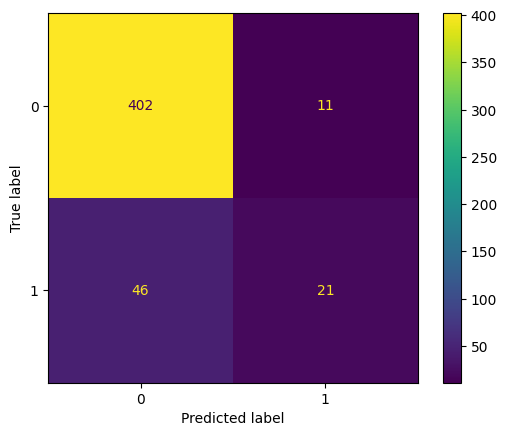

In [12]:
# Raw confusion matrix
raw_matrix = metrics.confusion_matrix(py_test, py_pred)
print(f"Confusion matrix:\n{raw_matrix}")

# nicerly visualized
metrics.ConfusionMatrixDisplay.from_predictions(py_test, py_pred);

**Receiver Operating Characteristic (ROC) and Precision-Recall Curves**

Classifiers usually work by computing some real value of an observation, and then thresholding, such that if that value is larger than the threshold, the observation is labeled as one class (say the positive class), while if it is smaller then it will be the other class.

These values are either computed as probabilities or through a decision function. More on these below.

Choosing a good threshold is not always trivial. Our running example (the SVM), has a 'natural', geometrically motivaded threshold of $0$. However, other thresholds could be better depending on our case and our data. To study those, we use the ROC curve and the PR curve.

The decision function values will be needed to compute the ROC curve:

In [13]:
# By default, SVC does not compute probabilities, but we can get the decision functions values:
py_dfunc_values = port_wine_pipeline.decision_function(pX_test)
py_dfunc_values[0:10]

array([-1.14128235, -1.42185719, -1.20725862, -1.08620746, -1.46669604,
       -1.10920953, -1.43406485, -1.18001663, -1.24976021, -1.2900564 ])

We can compute the raw ROC values:

In [14]:
# Will return false postive rates, true positive rates, and the threshold those values belong to
fpr, tpr, thresholds = metrics.roc_curve(py_test, py_dfunc_values)

Or we can use a handy way to display it (but miss the threshold values)

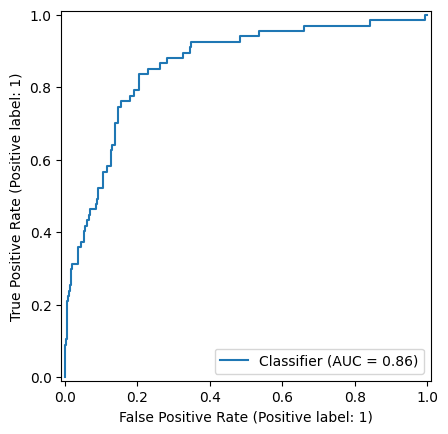

In [15]:
metrics.RocCurveDisplay.from_predictions(py_test, py_dfunc_values);

**Interpretation**
- Ideally we want our classifier to have as high a TPR and as low an FPR as possible. Hence, we must choose the threshold achieving the point closest to the top left (thresholds are not shown in the figure above).
- The curve is a visual summary of how our classifier works for a variety of thresholds, the area under the curve (AUC in the plot) is an aggregate of how the classifier performs over all thresholds.

**NOTE**

Some classifiers will use probabilities instead of the decision function. Furthermore, for some classifiers using decision functions, you can also convert decision function values to probabilities. In the case of SVC, you need to indicate `probability=True` when creating the `svm.SVC()` object.

Now let's compute the precision recall curve.

In [16]:
# Raw option, useful when thresholds are needed
pw_clf_precision, pw_clf_recall, pw_clf_pr_thresholds = metrics.precision_recall_curve(py_test, py_dfunc_values)

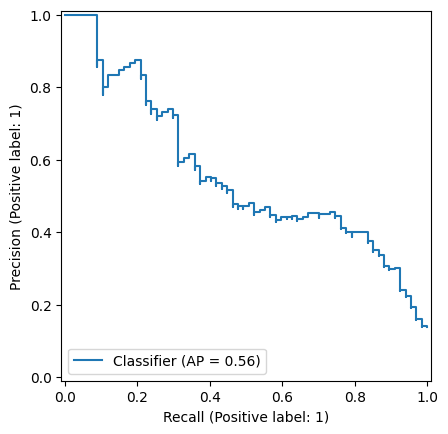

In [17]:
# Visual option, for quick overall reading of behavior
metrics.PrecisionRecallDisplay.from_predictions(py_test, py_dfunc_values);

Aha! The PR curve, which ideally is as pushed to the top right as possible, is pretty bad. This was not clear with the ROC curve. The PR curve is better at diagnosing problems when data is imbalanced.

#### <span style="color:red">EXERCISE</span>

1. Take a look at the confusion matrix in wikipedia and discuss with your neighbor the meaning of some terms like FPR, TPR, Precision, and Recall.
2. Discuss with your neighbors what the shapes of ROC and PR curves can tell us about a classifier.
3. Why, in the case of imbalanced data, would the PR be more informative than the ROC?